In [62]:
%load_ext autoreload
%autoreload 2
from src.functions import preprocess, evaluate_model, get_mi, plot_mi


df_train, df_test = preprocess()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, I'll create a function that gets the Mutual Information score for each feature. Then, we can get rid of features with mi = 0 (or features that are uninformative)

In [63]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = get_mi(X, y)
mi_scores

OverallQual             0.572936
Neighborhood_encoded    0.480028
GrLivArea               0.430796
YearBuilt               0.412356
LotArea                 0.393257
                          ...   
Foundation__Other       0.000000
LotConfig__Corner       0.000000
LotConfig__FR2          0.000000
LotConfig__Inside       0.000000
Heating__GasW           0.000000
Name: MI Scores, Length: 161, dtype: float64

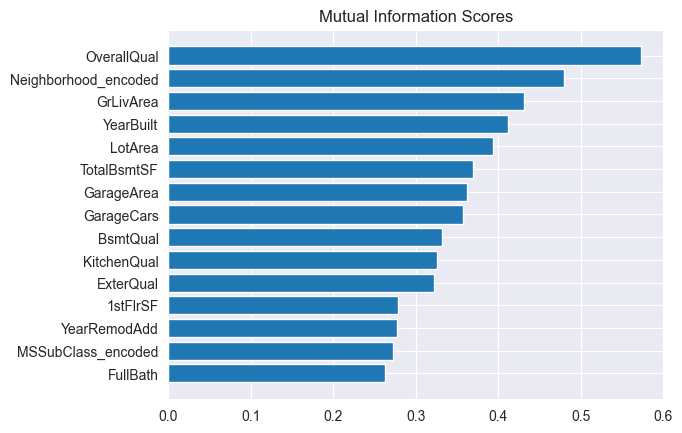

In [64]:
# plot top 15 scores
plot_mi(mi_scores.head(15));

In [65]:
mi_scores.sort_values(ascending=True)

Heating__GasW            0.000000
SaleCondition__Alloca    0.000000
SaleCondition__Family    0.000000
MiscFeature__Other       0.000000
RoofStyle__Gambrel       0.000000
                           ...   
LotArea                  0.393257
YearBuilt                0.412356
GrLivArea                0.430796
Neighborhood_encoded     0.480028
OverallQual              0.572936
Name: MI Scores, Length: 161, dtype: float64

Some features have a MI score of 0.0. It is better to drop those.

In [66]:
X = X.loc[:, mi_scores > 0.0]
X.shape

(1460, 137)

let's check the effect of dropping uninformative features

In [67]:
from xgboost import XGBRegressor

model = XGBRegressor()
rmsle, mae = evaluate_model(X_filtered, y, model)
print(f"RMSLE: {rmsle:.5f}")
print(f"MAE: {mae:.5f}")

RMSLE: 0.13680
MAE: 17024.35605
